In [1]:
import os, time
import numpy as np
import matplotlib.pyplot as plt

from pynq import Overlay

import mkidgen3
from mkidgen3.drivers.ppssync import *
from mkidgen3.server.feedline_config import *
from mkidgen3.server.waveform import WaveformFactory
from mkidgen3.drivers.ifboard import IFBoard
import mkidgen3.plotting
from mkidgen3.plotting import plot_waveforms, plot_comp_sat, plot_ddc
from mkidreadoutanalysis.mkidnoiseanalysis import plot_psd

from mkidgen3.util import rx_power, convert_freq_to_ddc_bin
import scipy.optimize as spo
#import scipy.signal as signal


 <a class="anchor" id="table"></a>
# Table of Contents
* [0.System Setup](#setup)
    * [0.0.3 Tune Power](#power)
* [1. FPGA Direct Loopback](#fpga)
    * [1.1 Phase Noise in 1 Channel](#phase1)
* [2. IF Board Loopback](#if)
    * [2.1.1 Phase Noise in 1 Channel, 1 Tone](#phase2)
    * [2.2.1 Phase Noise in 1 Channel, 2048 Tones](#phase3)
* [3. Fridge](#fridge)
    * [3.1 Phase Noise in 1 Channel](#phase3)

# 0.0 Start Clocking, Download Bitstream  <a class="anchor" id="setup"></a>

In [2]:
# Set Board Timezone
os.environ['TZ'] = 'right/UTC'
time.tzset()

In [3]:
# Download Overlay, Optionally Configure Clocks
bitstream='/home/xilinx/gen3_top_final.bit'
mkidgen3.drivers.rfdcclock.configure(programming_key='4.096GSPS_MTS_dualloop',clock_source='external')
time.sleep(0.5)
ol = Overlay(bitstream, ignore_version=True, download=True)
mkidgen3.quirks.Overlay(ol).post_configure()
ol.rfdc.enable_mts()
ol.rfdc.enable_mts()

## 0.0.1 Start PPS SYNC

In [4]:
ol.pps_synchronization.pps_synchronizer_con_0.start_engine(PPSMode.FORCE_START, skew = 1000*1000*1000,
                                                                  clk_period_ns=1/256e-3)

## 0.0.2 IF Board Initial Settings (Max Attn & Off)

In [62]:
ifb = IFBoard()
ifb.power_off()
ifb.set_attens(output_attens=60, input_attens=60)
#ifb.set_lo(6010.0)
print(ifb.status())

IFStatus: Unpowered, boot 151. LO gen3 fractional mode, full calibration. PLL locked.
	Req: 6000 MHz Attained: 6000 MHz Err: 0 MHz
	DAC attens: (31.75, 28.25)
	ADC Attens: (28.25, 31.75)


## 0.0.3 Tune ADC Power  <a class="anchor" id="power"></a>

In [6]:
# Adjust IF Attn
ifb = IFBoard()
ifb.power_on()
ifb.set_attens(output_attens=0, input_attens=23)
print(ifb.status())

IFStatus: Powered, boot 151. LO gen3 fractional mode, full calibration. PLL locked.
	Req: 6000 MHz Attained: 6000 MHz Err: 0 MHz
	DAC attens: (0.0, 0.0)
	ADC Attens: (0.0, 23.0)


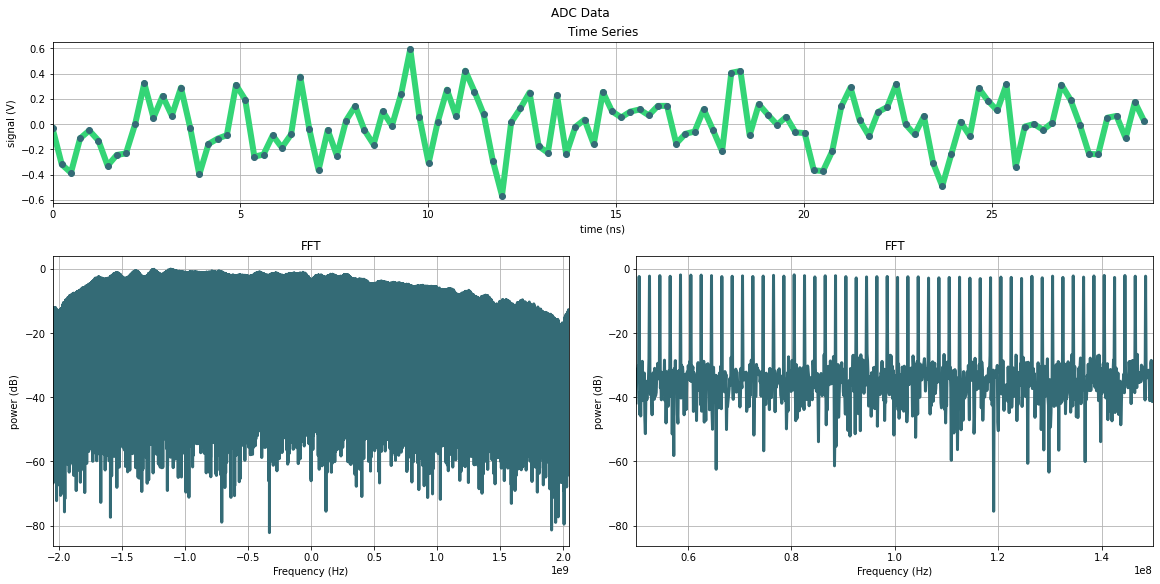

In [15]:
# Capture ADC
x = ol.capture.capture_adc(2**19, complex=False)  # throw away capture to clear any startup garbage
del x
adc_capture_data = ol.capture.capture_adc(2**19, complex=True)
adc_capture_data = adc_capture_data/2**15 # Normalize to 1/2 V
# Plot ADC Data
timerange = (0,120)  # ns
fftrange= (16, 16 + 20*4096) 
fftzoom = (0.5e8, 1.5e8)
mkidgen3.plotting.adc_test_plot(adc_capture_data, timerange, fftrange, fftzoom)

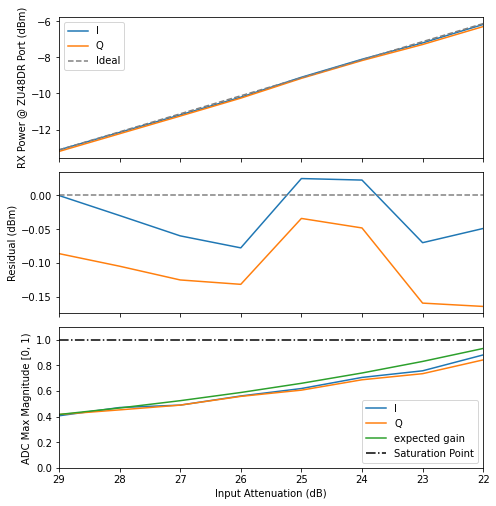

In [26]:
plot_comp_sat(ol, ifb, output_atten=0, input_range=(30, 22), figsize=(7, 7))
None

# 1.0 FPGA Direct Loopback Measurments  <a class="anchor" id="fpga"></a>
[Table of Contents](#table)

## Hardware Setup: Direct Loopback

<img src="img/direct_loopback.png" style="height:500px">

## 1.1 Phase Noise in a Channel  <a class="anchor" id="phase1"></a>

## 1.1.1 Single Tone, Most of DAC Dynamic Range

## 1.1.1 Single Tone, Realistic Fraction of DAC Dynamic Range

## 1.1.1 Single Tone, 2048 other Randomized tones

# 2.0 IF Board Loopback Measurments  <a class="anchor" id="if"></a>
[Table of Contents](#table)

## Hardware Setup: IF Board Loopback w/ 30 dB attn

<img src="img/if_loopback.png" style="height:500px">

## 2.1.1 Single Tone, Realistic Fraction of DAC Dynamic Range <a class="anchor" id="phase2"></a>

In [35]:
# Run DAC
tones = np.array([100e6])
wvfm_cfg = WaveformConfig(waveform=WaveformFactory(frequencies=tones, seed=6, dac_dynamic_range = 0.9, compute=True))
ol.dac_table.configure(**wvfm_cfg.settings_dict())

[0.0.3 Tune Power](#power)

In [36]:
# Bin2Res + DDC
chan = wvfm_cfg.default_channel_config
ol.photon_pipe.reschan.bin_to_res.configure(**chan.settings_dict())
ddc = wvfm_cfg.default_ddc_config
ol.photon_pipe.reschan.ddccontrol_0.configure(**ddc.settings_dict())

In [37]:
# Matched Filter
filtercfg=FilterConfig(coefficients=f'unity{2048}')
ol.photon_pipe.phasematch.configure(**filtercfg.settings_dict())

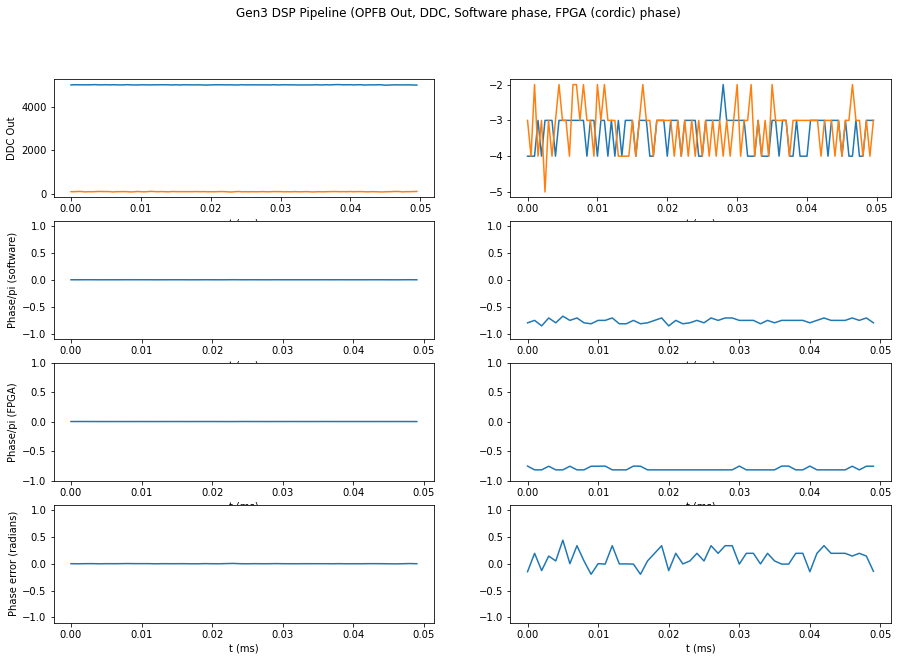

In [38]:
ddciq, phase = ol.capture.cap_cordic_compare()
chan_plt=[0,1]
plot_ddc(ddciq, phase, chan_plt)
None

In [39]:
# Capture Phase
x = ol.capture.capture_phase(2**19, [0,1], tap_location='filtphase')
phase = np.array(x)
x.freebuffer()
phase0 = np.pi*phase[:,0]/(2**15-1)

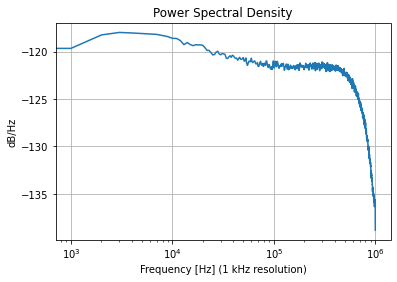

In [40]:
# Plot Phase PSD
plot_psd(phase0, fs=2e6, fres=1e3)

## 2.1.2 2048 Tones, Realistic Fraction of DAC Dynamic Range <a class="anchor" id="phase3"></a>

In [10]:
#random_tones = np.random.uniform(-2.048e9, 2.047e9, 2048)
#random_tones = np.random.uniform(-1.048e9, 1.047e9, 1024)

In [14]:
# Run DAC
#wvfm_cfg = WaveformConfig(waveform=WaveformFactory(frequencies=random_tones, dac_dynamic_range = 0.9, compute=True))
wvfm_cfg = WaveformConfig(waveform=WaveformFactory(n_uniform_tones=2048, dac_dynamic_range = 0.9, compute=True))
ol.dac_table.configure(**wvfm_cfg.settings_dict())

[0.0.3 Tune Power](#power)

Since we are running a lot of tones we will only program bin2res and the DDC to readout 1 to conserve some power for these tests. I beleive this is legit because there should be no leakage / crosstalk in the channels after the OPFB.

In [57]:
# Bin2Res + DDC
freq_idx = 1169
freq = wvfm_cfg.waveform.quant_freqs[freq_idx]

tone_bin = convert_freq_to_ddc_bin(freq)[0]
print(f'Readout freq {freq*1e-6} MHz in bin {tone_bin}')
bins = np.zeros(2048, dtype=int)
bins[0] = tone_bin

chan = ChannelConfig(bins=bins)

ddc_tones = np.zeros(2048)
ddc_tones[0] = freq

ddc = DDCConfig(tones=ddc_tones)

ol.photon_pipe.reschan.bin_to_res.configure(**chan.settings_dict())
ol.photon_pipe.reschan.ddccontrol_0.configure(**ddc.settings_dict())

Readout freq 290.5 MHz in bin 290


In [58]:
# Matched Filter
#filtercfg=FilterConfig(coefficients=f'unity{2048}')
#ol.photon_pipe.phasematch.configure(**filtercfg.settings_dict())

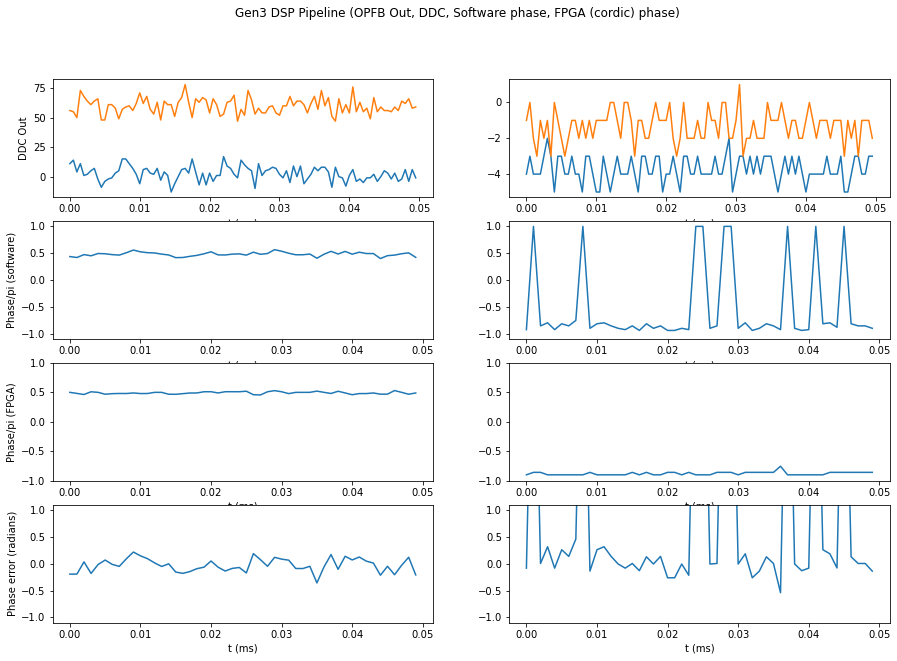

In [59]:
ddciq, phase = ol.capture.cap_cordic_compare()
chan_plt=[0,1]
plot_ddc(ddciq, phase, chan_plt)
None

In [60]:
# Capture Phase
x = ol.capture.capture_phase(2**19, [0,1], tap_location='filtphase')
phase = np.array(x)
x.freebuffer()
phase0 = np.pi*phase[:,0]/(2**15-1)

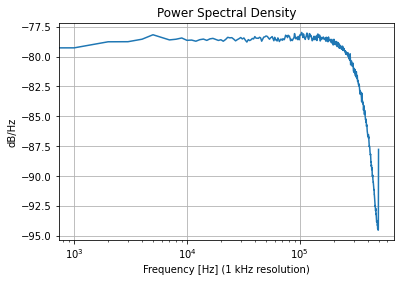

In [61]:
# Plot Phase PSD
plot_psd(phase0, fs=1e6, fres=1e3)

# 3.0 Fridge: Paramp + HEMT MKID Measurments  <a class="anchor" id="fridge"></a>
[Table of Contents](#table)

## Hardware Setup: Connected to WhiteFridge Elson Feedline 2

<img src="img/fridge.png" style="height:500px">